In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")


In [4]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

#### Exploratory Data Analysis

In [5]:
train.head(10)

,Date,Petrol (USD)
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28
5,7/14/2003,74.21
6,7/21/2003,75.07
7,7/28/2003,75.10
8,8/4/2003,75.12
9,8/11/2003,75.44


In [6]:
train.shape

(813, 2)

In [7]:
train.dtypes

Date             object
Petrol (USD)    float64
dtype: object

In [8]:
train.columns

Index(['Date', 'Petrol (USD)'], dtype='object')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813 entries, 0 to 812
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          813 non-null    object 
 1   Petrol (USD)  811 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.8+ KB


In [10]:
train.describe()

,Petrol (USD)
count,811.000000
mean,110.330481
std,19.241182
min,74.210000
25%,94.525000
50%,112.420000
75%,128.560000
max,189.510000


In [11]:
train.isnull().sum()

Date            0
Petrol (USD)    2
dtype: int64

In [12]:
# Display rows where any column has a null value
train_nulls = train[train.isnull().any(axis=1)]
train_nulls


,Date,Petrol (USD)
125,10/31/2005,NaN
180,11/20/2006,NaN


In [13]:
train['Date'].dtype

dtype('O')

In [14]:
# Convert 'Date' column to datetime format
train["Date"] = pd.to_datetime(train["Date"])

In [15]:
train['Date'].dtypes

dtype('<M8[ns]')

In [16]:
train.nunique()

Date            813
Petrol (USD)    754
dtype: int64

In [17]:
train.head()

,Date,Petrol (USD)
0,2003-06-09,74.59
1,2003-06-16,74.47
2,2003-06-23,74.42
3,2003-06-30,74.35
4,2003-07-07,74.28


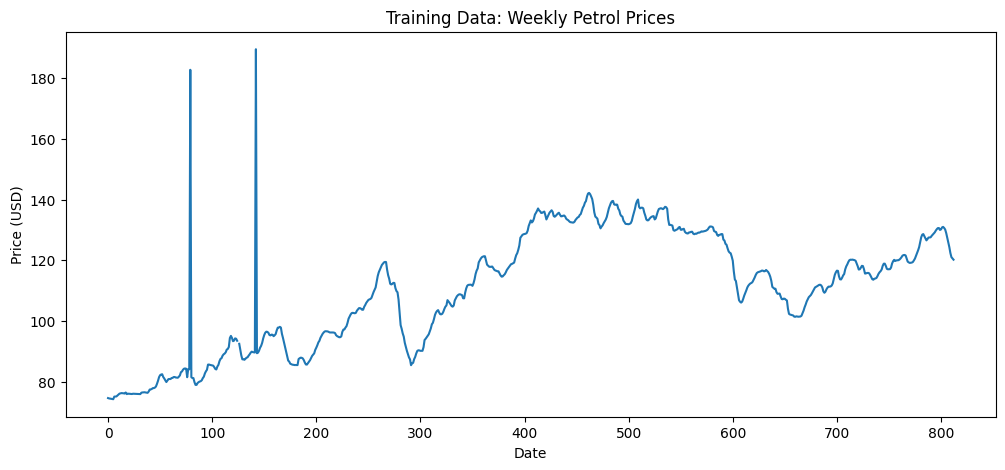

In [18]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train['Petrol (USD)'])
plt.title("Training Data: Weekly Petrol Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()


In [19]:
print("Mean:", train["Petrol (USD)"].mean())
print("Median:", train["Petrol (USD)"].median())
print("Mode:", train["Petrol (USD)"].mode()[0])  # Mode can have multiple values; take the first one


Mean: 110.33048088779287
Median: 112.42
Mode: 76.0


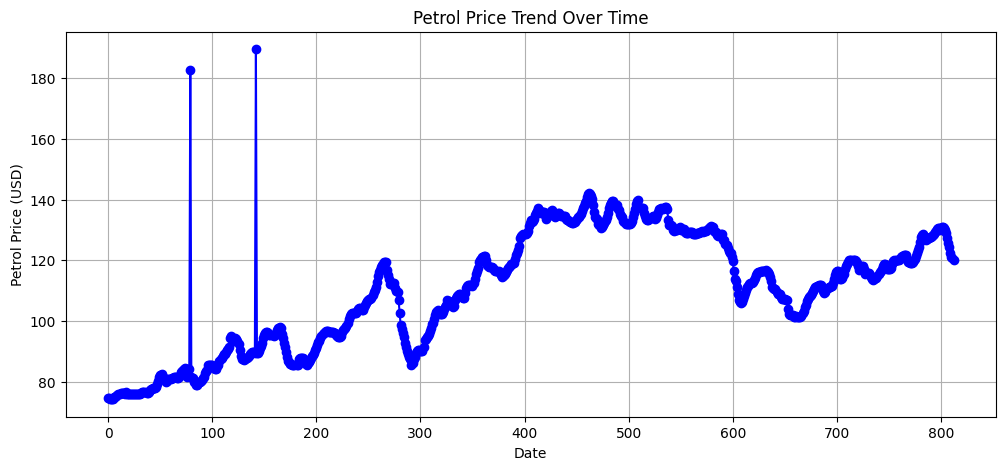

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train.index, train["Petrol (USD)"], marker="o", linestyle="-", color="blue")
plt.xlabel("Date")
plt.ylabel("Petrol Price (USD)")
plt.title("Petrol Price Trend Over Time")
plt.grid()
plt.show()


In [21]:
train.duplicated().sum()

np.int64(0)

In [22]:
# Find the two highest petrol prices
spikes = train.nlargest(2, "Petrol (USD)")
print(spikes)


          Date  Petrol (USD)
142 2006-02-27        189.51
79  2004-12-13        182.73


In [23]:
print(train.loc[120:130])  # Check values around index 125
print(train.loc[175:185])  # Check values around index 180


          Date  Petrol (USD)
120 2005-09-26         93.33
121 2005-10-03         93.51
122 2005-10-10         94.25
123 2005-10-17         94.14
124 2005-10-24         93.47
125 2005-10-31           NaN
126 2005-11-07         92.47
127 2005-11-14         90.53
128 2005-11-21         88.61
129 2005-11-28         87.35
130 2005-12-05         87.35
          Date  Petrol (USD)
175 2006-10-16         85.91
176 2006-10-23         85.74
177 2006-10-30         85.60
178 2006-11-06         85.54
179 2006-11-13         85.49
180 2006-11-20           NaN
181 2006-11-27         85.47
182 2006-12-04         85.46
183 2006-12-11         87.44
184 2006-12-18         87.70
185 2006-12-25         87.90


In [25]:
train["Petrol (USD)"] = train["Petrol (USD)"].interpolate(method="linear")



In [26]:
train.isnull().sum()

Date            0
Petrol (USD)    0
dtype: int64

In [27]:
print(train.loc[120:130])  # Check around index 125
print(train.loc[175:185])  # Check around index 180


          Date  Petrol (USD)
120 2005-09-26         93.33
121 2005-10-03         93.51
122 2005-10-10         94.25
123 2005-10-17         94.14
124 2005-10-24         93.47
125 2005-10-31         92.97
126 2005-11-07         92.47
127 2005-11-14         90.53
128 2005-11-21         88.61
129 2005-11-28         87.35
130 2005-12-05         87.35
          Date  Petrol (USD)
175 2006-10-16         85.91
176 2006-10-23         85.74
177 2006-10-30         85.60
178 2006-11-06         85.54
179 2006-11-13         85.49
180 2006-11-20         85.48
181 2006-11-27         85.47
182 2006-12-04         85.46
183 2006-12-11         87.44
184 2006-12-18         87.70
185 2006-12-25         87.90


In [28]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train["Petrol (USD)"])

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be needed.")



ADF Statistic: -2.039940767127709
p-value: 0.2693395700464476
The series is non-stationary. Differencing may be needed.


In [29]:
train["price_diff"] = train["Petrol (USD)"].diff().dropna()


In [30]:
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(train["price_diff"].dropna())
print(f"ADF Statistic after differencing: {result_diff[0]}")
print(f"p-value after differencing: {result_diff[1]}")

if result_diff[1] < 0.05:
    print("The series is now stationary.")
else:
    print("The series is still non-stationary. Further differencing may be needed.")


ADF Statistic after differencing: -16.599229506473407
p-value after differencing: 1.7705918524907045e-29
The series is now stationary.


In [31]:
train.head()

,Date,Petrol (USD),price_diff
0,2003-06-09,74.59,NaN
1,2003-06-16,74.47,-0.12
2,2003-06-23,74.42,-0.05
3,2003-06-30,74.35,-0.07
4,2003-07-07,74.28,-0.07


In [32]:
train.isnull().sum()

Date            0
Petrol (USD)    0
price_diff      1
dtype: int64

In [34]:
train["price_diff"] = train["price_diff"].fillna(0)
train.head()

,Date,Petrol (USD),price_diff
0,2003-06-09,74.59,0.00
1,2003-06-16,74.47,-0.12
2,2003-06-23,74.42,-0.05
3,2003-06-30,74.35,-0.07
4,2003-07-07,74.28,-0.07


In [36]:
train.reset_index(inplace=True)
train.head()

,index,Date,Petrol (USD),price_diff
0,0,2003-06-09,74.59,0.00
1,1,2003-06-16,74.47,-0.12
2,2,2003-06-23,74.42,-0.05
3,3,2003-06-30,74.35,-0.07
4,4,2003-07-07,74.28,-0.07


In [38]:
model = ARIMA(train['Petrol (USD)'], order=(5,1,0))
model_fit = model.fit()

model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Petrol (USD)   No. Observations:                  813
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2568.291
Date:                Sat, 17 Jan 2026   AIC                           5148.581
Time:                        20:57:27   BIC                           5176.778
Sample:                             0   HQIC                          5159.405
                                - 813                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7225      0.008    -91.366      0.000      -0.738      -0.707
ar.L2         -0.4980      0.012    -40.708      0.000      -0.522      -0.474
ar.L3         -0.3315      0.017    -19.785      0.000      -0.364      -0.299
ar.L4         -0.1896      0.020     -9.453      0.000      -0.229      -0.150
ar.L5         -0.0834      0.021     -3.938      0.000      -0.125      -0.042
sigma2        32.6918      0.153    213.316      0.000      32.391      32.992
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):           1719220.02
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            12.26
Prob(H) (two-sided):                  0.00   Kurtosis:                       227.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
predictions = model_fit.forecast(steps=len(test))


In [48]:
steps = len(test)
forecast = model_fit.forecast(steps=steps)


In [49]:
test['Predicted Petrol Price'] = forecast
test.drop(columns=['Prediction'], inplace=True, errors='ignore')


In [58]:
test.head()

,Date,Predicted Petrol Price
0,1/1/2019,121.630953
1,1/2/2019,121.349765
2,1/3/2019,121.163195
3,1/4/2019,121.072849
4,1/5/2019,121.084935


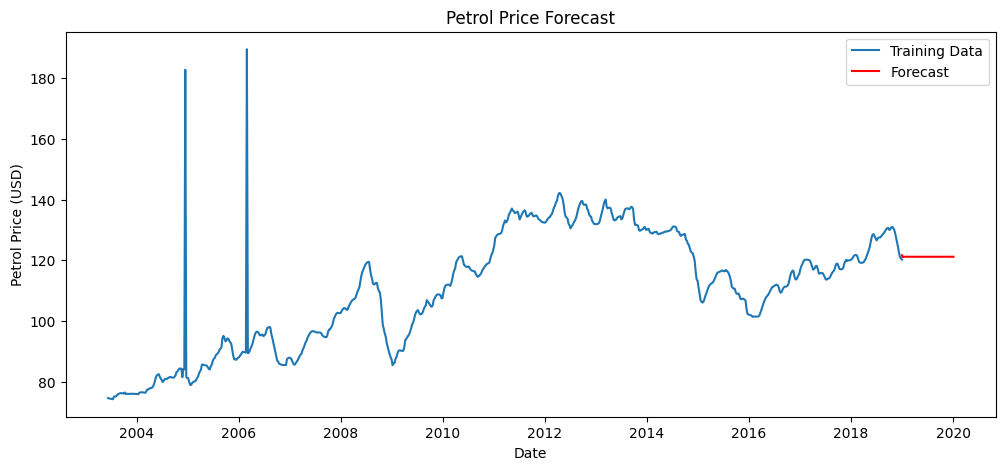

In [76]:
test['Date'] = pd.to_datetime(test['Date'], errors='coerce')
train['Date'] = pd.to_datetime(train['Date'], errors='coerce')

train = train.set_index('Date')
test = test.set_index('Date')

train = train.sort_index()
test = test.sort_index()



plt.figure(figsize=(12,5))
plt.plot(train.index, train['Petrol (USD)'], label='Training Data')
plt.plot(test.index, test['Predicted Petrol Price'], label='Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Petrol Price (USD)')
plt.title('Petrol Price Forecast')
plt.show()



In [ ]:
test['Predicted Petrol Price'] = forecast.values

In [56]:
test.head()

,Date,Predicted Petrol Price
0,1/1/2019,121.630953
1,1/2/2019,121.349765
2,1/3/2019,121.163195
3,1/4/2019,121.072849
4,1/5/2019,121.084935


In [71]:
test[['Date', 'Predicted Petrol Price']].to_csv(
    "petrol_price_forecast.csv",
    index=False
)


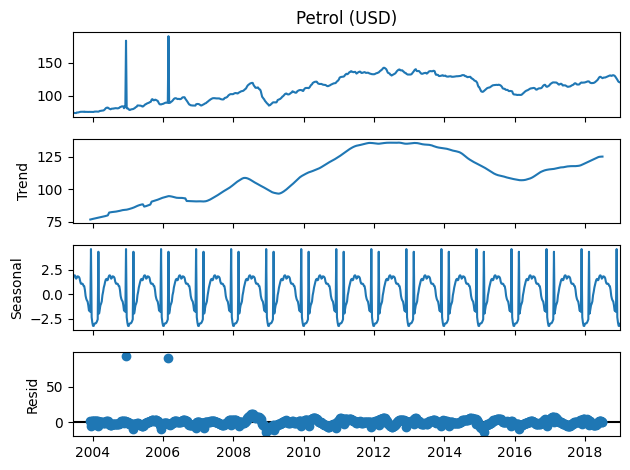

In [176]:
import pandas as pd
import statsmodels.api as sm

df.set_index("Date", inplace=True)  # Make Date the index
decomposition = sm.tsa.seasonal_decompose(df["Petrol (USD)"], model="additive", period=52)
decomposition.plot()
plt.show()


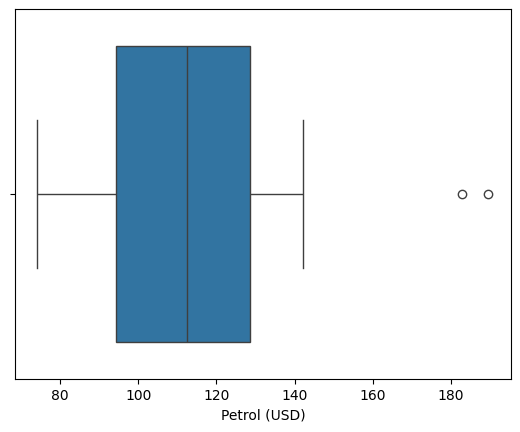

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df["Petrol (USD)"])
plt.show()


In [181]:
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week
df["Day"] = df["Date"].dt.day
df["Day_of_Week"] = df["Date"].dt.weekday


In [182]:
df.head()

,Date,Petrol (USD),price_diff,Year,Month,Week,Day,Day_of_Week
0,2003-06-09,74.59,0.00,2003,6,24,9,0
1,2003-06-16,74.47,-0.12,2003,6,25,16,0
2,2003-06-23,74.42,-0.05,2003,6,26,23,0
3,2003-06-30,74.35,-0.07,2003,6,27,30,0
4,2003-07-07,74.28,-0.07,2003,7,28,7,0


In [183]:
df.columns

Index(['Date', 'Petrol (USD)', 'price_diff', 'Year', 'Month', 'Week', 'Day',
       'Day_of_Week'],
      dtype='object')

In [184]:
df["Prev_Week"] = df["Petrol (USD)"].shift(1)  # Previous week's price
df["Prev_Month"] = df["Petrol (USD)"].shift(4)  # Approx previous month (4 weeks)


In [185]:
df.head()

,Date,Petrol (USD),price_diff,Year,Month,Week,Day,Day_of_Week,Prev_Week,Prev_Month
0,2003-06-09,74.59,0.00,2003,6,24,9,0,NaN,NaN
1,2003-06-16,74.47,-0.12,2003,6,25,16,0,74.59,NaN
2,2003-06-23,74.42,-0.05,2003,6,26,23,0,74.47,NaN
3,2003-06-30,74.35,-0.07,2003,6,27,30,0,74.42,NaN
4,2003-07-07,74.28,-0.07,2003,7,28,7,0,74.35,74.59


In [186]:
df.isnull().sum()

Date            0
Petrol (USD)    0
price_diff      0
Year            0
Month           0
Week            0
Day             0
Day_of_Week     0
Prev_Week       1
Prev_Month      4
dtype: int64

In [187]:
df["Prev_Week"] = df["Prev_Week"].bfill()  # Use bfill() instead of fillna(method="bfill")
df["Prev_Month"] = df["Prev_Month"].fillna(df["Petrol (USD)"].shift(4))  # Fill with previous month's value
# df["Prev_Month"].fillna(df["Prev_Month"].mean(), inplace=True)  # If still missing, use average


In [189]:

# If there are still NaNs, fill them with the mean
df["Prev_Month"] = df["Prev_Month"].fillna(df["Prev_Month"].mean())

df.head()

,Date,Petrol (USD),price_diff,Year,Month,Week,Day,Day_of_Week,Prev_Week,Prev_Month
0,2003-06-09,74.59,0.00,2003,6,24,9,0,74.59,110.225328
1,2003-06-16,74.47,-0.12,2003,6,25,16,0,74.59,110.225328
2,2003-06-23,74.42,-0.05,2003,6,26,23,0,74.47,110.225328
3,2003-06-30,74.35,-0.07,2003,6,27,30,0,74.42,110.225328
4,2003-07-07,74.28,-0.07,2003,7,28,7,0,74.35,74.590000


In [190]:
# Creating lag features
df["lag1"] = df["price_diff"].shift(1)
df["lag7"] = df["price_diff"].shift(7)  # Weekly pattern
df["rolling_mean"] = df["price_diff"].rolling(window=7).mean()

# Drop NaN values after differencing
df.dropna(inplace=True)


In [191]:
df.head()

,Date,Petrol (USD),price_diff,Year,Month,Week,Day,Day_of_Week,Prev_Week,Prev_Month,lag1,lag7,rolling_mean
7,2003-07-28,75.10,0.03,2003,7,31,28,0,75.07,74.35,0.86,0.00,0.072857
8,2003-08-04,75.12,0.02,2003,8,32,4,0,75.10,74.28,0.03,-0.12,0.092857
9,2003-08-11,75.44,0.32,2003,8,33,11,0,75.12,74.21,0.02,-0.05,0.145714
10,2003-08-18,75.81,0.37,2003,8,34,18,0,75.44,75.07,0.32,-0.07,0.208571
11,2003-08-26,76.05,0.24,2003,8,35,26,1,75.81,75.10,0.37,-0.07,0.252857


In [192]:
# Create lag features for 14 and 30 days
df["lag_14"] = df["price_diff"].shift(14)
df["lag_30"] = df["price_diff"].shift(30)
df["ema_7"] = df["Petrol (USD)"].ewm(span=7, adjust=False).mean()  # 7-day EMA
df["ema_30"] = df["Petrol (USD)"].ewm(span=30, adjust=False).mean()  # 30-day EMA
# Define seasonal periods
summer_months = [6, 7, 8]  # June, July, August
winter_months = [12, 1, 2]  # December, January, February

# Create seasonal indicators
df["is_summer"] = df["Month"].apply(lambda x: 1 if x in summer_months else 0)
df["is_winter"] = df["Month"].apply(lambda x: 1 if x in winter_months else 0)
df.dropna(inplace=True)


In [193]:
df.head()

,Date,Petrol (USD),price_diff,Year,Month,Week,Day,Day_of_Week,Prev_Week,Prev_Month,lag1,lag7,rolling_mean,lag_14,lag_30,ema_7,ema_30,is_summer,is_winter
37,2004-02-23,76.38,-0.06,2004,2,9,23,0,76.44,76.44,-0.06,-0.06,0.071429,-0.01,0.03,76.342167,76.004213,0,1
38,2004-03-01,76.32,-0.06,2004,3,10,1,0,76.38,76.48,-0.06,0.02,0.060000,0.09,0.02,76.336626,76.024587,0,0
39,2004-03-08,76.73,0.41,2004,3,11,8,0,76.32,76.50,-0.06,0.46,0.052857,-0.02,0.32,76.434969,76.070097,0,0
40,2004-03-15,77.39,0.66,2004,3,12,15,0,76.73,76.44,0.41,0.08,0.135714,-0.03,0.37,76.673727,76.155252,0,0
41,2004-03-22,77.44,0.05,2004,3,13,22,0,77.39,76.38,0.66,0.04,0.137143,-0.01,0.24,76.865295,76.238139,0,0


In [204]:
from sklearn.model_selection import train_test_split

# Define feature columns (excluding target and Date)
features = [ "Year", "Month", "Week", "Day", "Prev_Week", "lag1", "lag7"]

# Define target variable (actual price, not price_diff)
target = "Petrol (USD)"

# Train-test split (e.g., 80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, X_test = train[features], test[features]
y_train, y_test = train[target], test[target]


In [205]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train XGBoost model
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost Results:\nMAE: {mae_xgb}\nRMSE: {rmse_xgb}")


XGBoost Results:
MAE: 0.8047726831680695
RMSE: 1.044452398638425


In [206]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA model (p, d, q values can be tuned)
arima_model = ARIMA(train[target], order=(5, 1, 2))  # p=5, d=1, q=2
arima_model = arima_model.fit()

# Forecast for test period
y_pred_arima = arima_model.forecast(steps=len(test))

# Evaluate performance
mae_arima = mean_absolute_error(y_test, y_pred_arima)
rmse_arima = np.sqrt(mean_squared_error(y_test, y_pred_arima))

print(f"ARIMA Results:\nMAE: {mae_arima}\nRMSE: {rmse_arima}")


D:\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
D:\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
D:\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA Results:
MAE: 14.235482942314624
RMSE: 15.901003258522222


D:\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [207]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Normalize data for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM input (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define LSTM model
lstm_model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(1, len(features))),
    LSTM(50, activation="relu"),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, verbose=1)

# Predict on test set
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Evaluate performance
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

print(f"LSTM Results:\nMAE: {mae_lstm}\nRMSE: {rmse_lstm}")


Epoch 1/50


D:\ml_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12437.2129 
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12771.1885
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11696.0703 
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7065.7637
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1541.4099
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 662.0623  
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 558.0823
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 539.8939 
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 428.7065 
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 406.2650 
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 347.1369
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 296.7943 
Epoch 13/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 258.6758
Epoch 14/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 196.1839 
Epoch 15/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

In [208]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest Results:\nMAE: {mae_rf}\nRMSE: {rmse_rf}")


Random Forest Results:
MAE: 0.5547709412357996
RMSE: 0.6864757543914124


In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df["Petrol (USD)"] = scaler.fit_transform(df[["Petrol (USD)"]])


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Petrol (USD)", "Date",])  # Features
y = df["Petrol (USD)"]  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # No shuffling in time-series


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)

print("Random Forest Results:")
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("RMSE:", mean_squared_error(y_test, rf_preds, squared=False))


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)

print("XGBoost Results:")
print("MAE:", mean_absolute_error(y_test, xgb_preds))
print("RMSE:", mean_squared_error(y_test, xgb_preds, squared=False))


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

gb_preds = gb_model.predict(X_test)

print("Gradient Boosting Results:")
print("MAE:", mean_absolute_error(y_test, gb_preds))
print("RMSE:", mean_squared_error(y_test, gb_preds, squared=False))


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [5, 10, 20, None],  # Maximum depth of trees
    "min_samples_split": [2, 5, 10],  # Min samples needed to split a node
    "min_samples_leaf": [1, 2, 4]  # Min samples per leaf node
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring="neg_mean_absolute_error", 
                           n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the final model with best parameters
best_rf = grid_search.best_estimator_


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

rf_preds_tuned = best_rf.predict(X_test)

print("Tuned Random Forest Results:")
print("MAE:", mean_absolute_error(y_test, rf_preds_tuned))
print("RMSE:", mean_squared_error(y_test, rf_preds_tuned, squared=False))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance scores
feature_importances = best_rf.feature_importances_
features = X.columns

# Sort and plot
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10,5))
plt.title("Feature Importance")
plt.bar(range(len(features)), feature_importances[indices], align="center")
plt.xticks(range(len(features)), np.array(features)[indices], rotation=45)
plt.show()
